<a href="https://colab.research.google.com/github/royam0820/DL/blob/master/Copy_of_Deep_learning_for_Malaria_detection_Data_Augementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Analysis for Malaria
Malaria.  Learn to classify blood smear images using a high-level deep learning environment.

References:


[1] https://www.who.int/news-room/fact-sheets/detail/malaria

[2] https://www.cdc.gov/malaria/diagnosis_treatment/diagnosis.html

[3] https://towardsdatascience.com/deep-learning-and-medical-image-analysis-for-malaria-detection-with-fastai-c8f08560262f

### Preliminary works: Update fastai, get the data and arranging it

In [0]:
# Get the fastai libraries and other important stuff: https://course.fast.ai/start_colab.html
!curl -s https://course.fast.ai/setup/colab | bash

In [2]:
# Get the data
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip

--2019-08-03 12:52:31--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  42.9MB/s    in 8.3s    

2019-08-03 12:52:41 (40.5 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [3]:
!ls

cell_images.zip  data  models


In [4]:
!pwd

/content


In [0]:
!unzip cell_images.zip

In [6]:
!ls

cell_images  cell_images.zip  data  models


### Only a few imports

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import *

import numpy as np
np.random.seed(7)

In [9]:
!apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 4 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (79.1 kB/s)
Selecting previously unselected package tree.
(Reading database ... 131289 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
# Data directory structure
!tree --dirsfirst --filelimit 10 /content/cell_images/

/content/cell_images/
├── Parasitized [13780 entries exceeds filelimit, not opening dir]
└── Uninfected [13780 entries exceeds filelimit, not opening dir]

2 directories, 0 files


### Creating the `ImageDataBunch` along with data augmentation and eyeballing at the data

Applying image transformation and additionally some cutout() on the image to force the CNN to look more completely at the entire image for classification clues,

In [22]:
# Transformation values taken from https://bit.ly/2Wj13Nt
#tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=20., max_zoom=0.05)
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=20., max_zoom=0.05, xtra_tfms = [cutout(n_holes=(1,2), length=(3, 3), p=.05)])
len(tfms)

2

NOTE1: we have added a special transformation called cutout. 
- get_transforms() we can add to this function, an additional list of transformations: extra_tfms


NOTE2:  tfms = [cutout()]

Article: https://forums.fast.ai/t/progressive-sprinkles-cutout-variation-my-new-data-augmentation-98-on-nih-malaria-dataset/50454

If you take a random grid/series of small squares, and randomly sprinkle holes on the image, and slowly increase their probability and sizes, then you can force the CNN to look more completely at the entire image for classification clues, while at the same time, in most cases, avoid blocking out enough data that would block it from truly learning.


Ref.: https://docs.fast.ai/vision.transform.html#_cutout

Cut out n_holes number of square holes of size length in image at random locations.

The normalization technique described in this paper: Improved Regularization of Convolutional Neural Networks with Cutout

By default, it will apply a single cutout (n_holes=1) of length=40) with probability p=1. The cutout position is always random. If you choose to do multiple cutouts, they may overlap.

The paper above used cutouts of size 16x16 for CIFAR-10 (10 categiries classification) and cutouts of size 8x8 for CIFAR-100 (100 categories). Generally, the more categories, the less cutout you want.

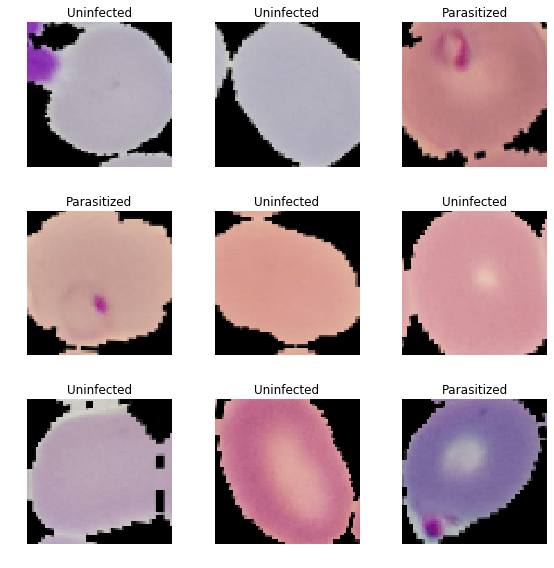

In [23]:
path = '/content/cell_images/'
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid_pct=0.1,
                                  size=64, bs=32).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(8,8))

Images are resized to 64x64 and batches of 32 images have been prepared. 

In [24]:
# Labels of the data
print(data.classes)

['Parasitized', 'Uninfected']


### Looking at a few single samples

(Image (3, 64, 64), Category Uninfected)


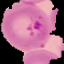

In [25]:
print(data.train_ds[10])
data.valid_ds[10][0]

(Image (3, 64, 64), Category Uninfected)


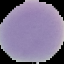

In [26]:
print(data.valid_ds[0])
data.valid_ds[0][0]

### A brief look at the important details of the data

In [27]:
data.label_list

LabelLists;

Train: LabelList (24803 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Uninfected,Uninfected,Uninfected,Uninfected,Uninfected
Path: /content/cell_images;

Valid: LabelList (2755 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Uninfected,Parasitized,Parasitized,Parasitized,Parasitized
Path: /content/cell_images;

Test: None

In [0]:
# save the databunch
bs=32
size= 64
data.save('/content/imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')

## Data Augmentation Blend
Ref.: https://forums.fast.ai/t/data-augmentation-dynamic-blend/50869/3

There are mainly 4 types of blend:

- Zero: you mask a subregion in an image and set it to zero (black).
- Noise: you mask a subregion in an image with random noise.
- Mix: where you take a weighted average of 2 different regions of the same size.
- Cut: you replace a certain region from an image with another region of the same size (this is similar to mix with weights of 0% for the input region and 100% for the cropping region).

The size and number of modified regions also varies from the entire image, to a single smaller region to multiple regions.

In all these cases, the cropping region is either zero, noise or comes from another image. But it could also come from the same image (self blending the image).

In [35]:
!git clone https://github.com/oguiza/fastai_extensions

Cloning into 'fastai_extensions'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 99 (delta 34), reused 75 (delta 19), pack-reused 0
Unpacking objects: 100% (99/99), done.


In [0]:
import sys
sys.path.append('/content/fastai_extensions/shared/0_image_data_augmentation/exp')

In [0]:
#from exp.nb_new_data_augmentation import *
import nb_new_data_augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


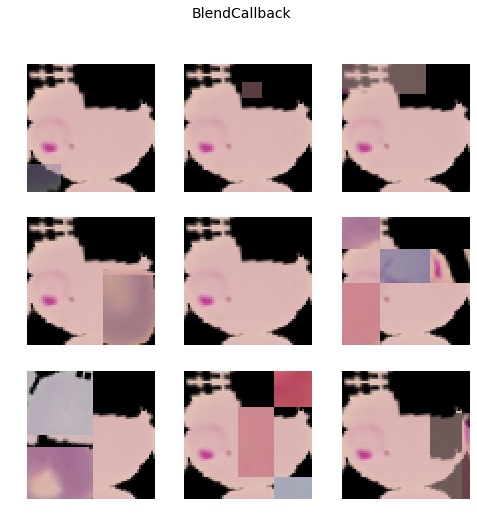

In [38]:
#from exp.nb_new_data_augmentation import *
kwargs = {
    'size': .3,            # range(0.-1.) You can indicate the size of the patched area/s
    'alpha': 1.,           # This is used to define a proba distribution
    'fixed_proba': 0,      # This overrides alpha proba distribution. Will fix the % of the image that is modified
    'grid': True,          # Determine if patches may overlap or not. With True they do not overlap
    'blend_type': 'random', # Options: 'zero', 'noise', 'mix', 'cut', 'random'
    'same_size': False,    # All patches may have the same size or not
    'same_crop': False,    # Cropping patches are from the same subregion as input patches (only with 'mix' and 'cut')
    'same_image': False,   # Cropping patches will be from the same or different images (only with 'mix' and 'cut')
}
learn = Learner(data,models.resnet50()).blend(**kwargs).show_tfms()

## Start of the modeling process - ResNet34

Here, we are using a pretrained **ResNet34** architecture. 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 104866146.04it/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.311084,0.216659,0.917241,02:06
1,0.218896,0.150397,0.947005,02:03
2,0.201351,0.134326,0.952813,02:05
3,0.191125,0.125875,0.956080,02:04
4,0.173041,0.125675,0.956080,02:04


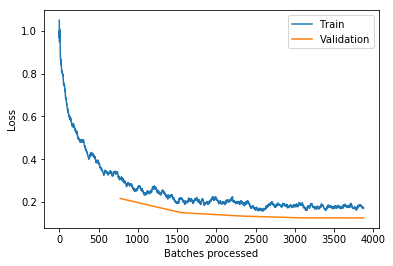

In [28]:
# Training in mixed precision policy + 1cycle policy: https://docs.fast.ai/basic_train.html#fit_one_cycle
learn = cnn_learner(data, models.resnet34, metrics=[accuracy]).to_fp16()
learn.fit_one_cycle(5);
learn.recorder.plot_losses()

Approximately **10 minutes** of training with mixed precision policy and a pretrained ResNet34 and we have got an accuracy score of **95.6080%**. 

The validation losses are only calculated once per epoch, whereas training losses are calculated after every batch.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


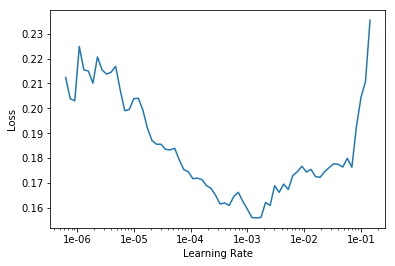

In [29]:
# Finding a good learning rate
learn.lr_find()
learn.recorder.plot()

In [30]:
# Training the network for a bit more
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-04, 1e-04/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.155765,0.132448,0.958984,02:21
1,0.150557,0.116064,0.957895,02:20
2,0.137712,0.105513,0.964065,02:20
3,0.115619,0.102615,0.963339,02:21
4,0.107146,0.095017,0.963339,02:24


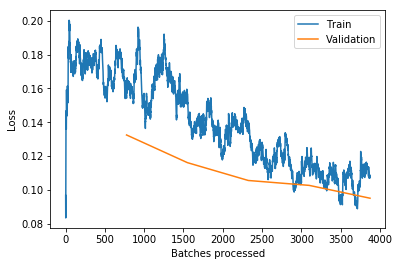

In [31]:
learn.recorder.plot_losses()

Training for more **8 minutes 31 seconds**.

In [0]:
# Training a bit more but this time in a little bit different way: no different learning rate in the last layers
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.099616,0.092684,0.970236,01:25
1,0.104648,0.096377,0.968421,01:27
2,0.090864,0.091235,0.969147,01:25
3,0.097922,0.090419,0.970236,01:27
4,0.092335,0.091098,0.972051,01:26


In [0]:
learn.save('Stage-1-rn34')

**8 minutes and 30 seconds** but this time it is separate because the slicing of the learning rates is different here. So we have got two training times: **16 minutes 31 seconds** and **16 mniutes 30 seconds** (the latest one). We have got a score of **97.20%**. 

Now, Adrian followed a split of 80:10:10 (train:valid:test). So, we can change the `valid_pct` argument in the `from_folder()`method from ** 0.1** to **0.2**.

In [0]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid_pct=0.2,
                                  size=64, bs=32).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy]).to_fp16()
# Reusing the weights from our previously saved model
learn.load('Stage-1-rn34')
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.108727,0.080655,0.971693,01:15


Another **1 minute and 15 seconds** of training. So a total of **17 minutes 45** seconds. 

In [0]:
# Save and export the model
learn.save('Stage-2-rn34-80_20')
learn.export('Malaria-Detection-Model.pkl')

The model weighs **41.8** MB whereas Adrian's model weighs **17.7** MB. But we have got better **training time** and **accuracy score**. Let's break the evaluation metrics a bit more. 

In [0]:
# Validation loss and accuracy
learn.validate(learn.data.valid_dl)

[0.080654584, tensor(0.9717)]

As we can see, we have an accuracy of **97.17%** on the validation set which is *clearly better* than the previous SOTA score. 

In [0]:
# Training loss and accuracy
learn.validate(learn.data.train_dl)

[0.09149353, tensor(0.9678)]

### Seeing the model's prediction results

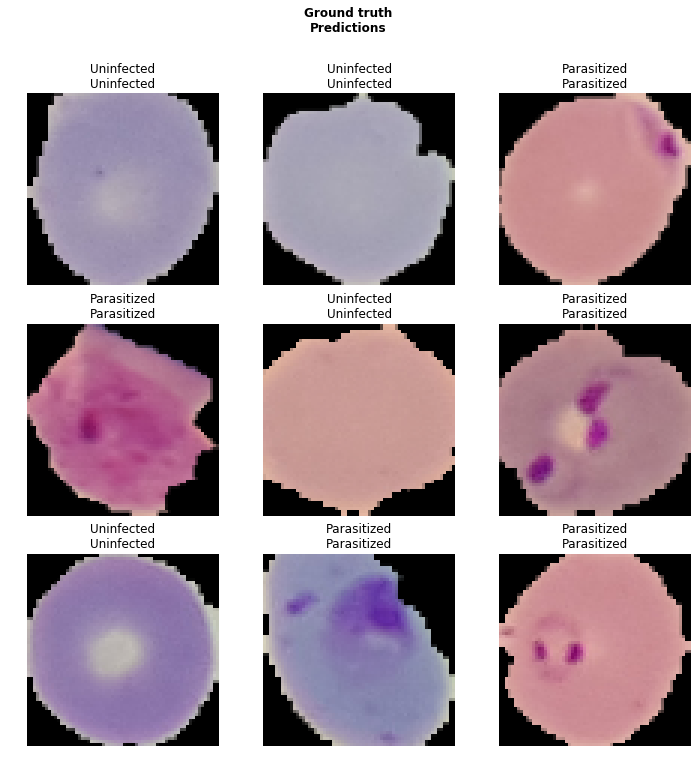

In [0]:
learn.show_results(ds_type=DatasetType.Valid, rows=3)

### Creating an `sklearn` like `classification_report`

In [0]:
# Getting the prediction label of single image (from the validation set)
str(learn.predict(learn.data.valid_ds[0][0])[0])

'Uninfected'

In [0]:
# Getting the ground truth from a single image (of validation set)
str(learn.data.valid_ds[0]).split('), ', 1)[1].replace('Category ', '').replace(')', '')

'Uninfected'

In [0]:
ground_truth = []
pred_labels = []

for i in range(len(learn.data.valid_ds)):
  temp_pred = str(learn.predict(learn.data.valid_ds[i][0])[0])
  temp_truth = str(learn.data.valid_ds[i]).split('), ', 1)[1].replace('Category ', '').replace(')', '')
  pred_labels.append(temp_pred)
  ground_truth.append(temp_truth)
  
assert len(pred_labels) == len(ground_truth)

In [0]:
pred_labels[:5], ground_truth[:5]

(['Uninfected', 'Uninfected', 'Parasitized', 'Parasitized', 'Uninfected'],
 ['Uninfected', 'Uninfected', 'Parasitized', 'Parasitized', 'Uninfected'])

In [0]:
from sklearn.metrics import classification_report

print(classification_report(ground_truth, pred_labels, target_names=data.classes))

              precision    recall  f1-score   support

 Parasitized       0.97      0.97      0.97      2707
  Uninfected       0.97      0.98      0.97      2804

   micro avg       0.97      0.97      0.97      5511
   macro avg       0.97      0.97      0.97      5511
weighted avg       0.97      0.97      0.97      5511



Here's Adrian's classification report: 

![](https://i.ibb.co/LtcxBVr/Capture-1.png)

As we can see, our model has got a better **recall**. 

### Seeing model's top losses

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

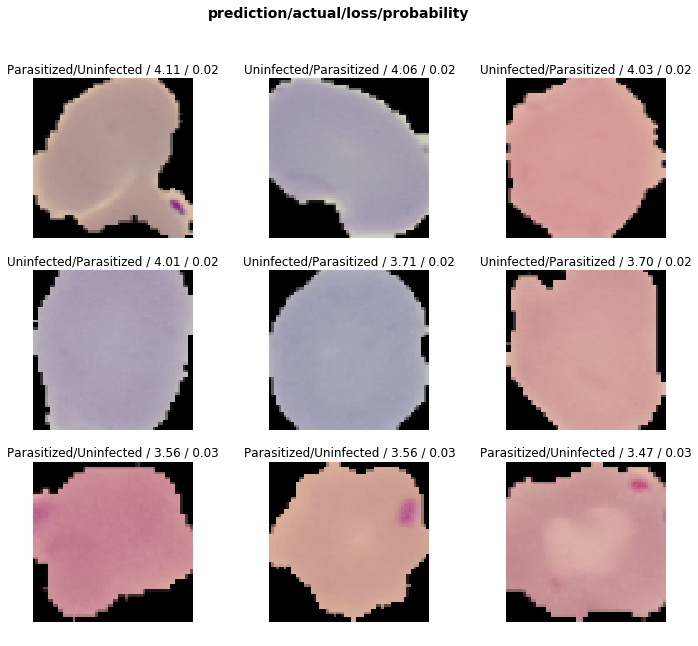

In [0]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)